<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/Brace_Angles_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brace Dataset
GitHub: https://github.com/dmoltisanti/brace.git
This repository contains the dataset published with the ECCV 2022 paper "BRACE: The Breakdancing Competition Dataset for Dance Motion Synthesis".![head_floor.PNG](head_floor.PNG)

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/capstone/brace

/content/drive/MyDrive/Github/capstone/brace


In [3]:
%ls

annotations/    dataClips       figures/            labels  __pycache__/
baseline_best/  dataset/        hypermodel_tuning/  names   README.md
best_full/      features_best/  keras_tuner/        path/   utils/


In [4]:
pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.3 MB/s eta 0:00:00


In [5]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [6]:
%ls

annotations/    dataClips       figures/            labels  __pycache__/
baseline_best/  dataset/        hypermodel_tuning/  names   README.md
best_full/      features_best/  keras_tuner/        path/   utils/


In [7]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image
import random as python_random
import importlib.util
import sys

In [8]:
sys.path.insert(0,'/content/drive/MyDrive/Github/capstone/brace/utils/')
import keypoints_angles
from keypoints_angles import body_parts, calculate_angle, calculate_angle_to_horizontal, calculate_hand_to_floor_distance, calculate_head_position
from keypoints_angles import calculate_head_to_floor_distance, calculate_leg_angles, calculate_mean_angles, calculate_mean_distance
from keypoints_angles import calculate_mean_hand_distance, calculate_mean_leg_angles, extract_angles_from_dataset, extract_hand_to_floor_distances
from keypoints_angles import extract_head_to_floor_distances, extract_horizontal_angles_from_df, plot_hand_distance_3x2_with_category_names
from keypoints_angles import plot_head_to_floor_histograms, plot_hip_knee_floor, plot_hip_leg_angle, angles_distance_segments

In [11]:
#CNN models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Input, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from keras_tuner.tuners import RandomSearch
#dimensionality reduction and clustering
from dtaidistance import dtw
from dtaidistance import dtw
from dtaidistance import clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Hyper parameter tuning
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Dropout
from tensorflow.keras.models import Model
from keras_tuner import HyperModel
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.initializers import GlorotUniform
import shutil

In [12]:
def reset_random_seeds():
   np.random.seed(42)
   python_random.seed(42)
   tf.random.set_seed(42)
   import os
   os.environ['PYTHONHASHSEED'] = '0'

reset_random_seeds()

# Disable all GPUs
tf.config.set_visible_devices([], 'GPU')


In [13]:
df_body_parts = pd.DataFrame(list(body_parts().keys()), index=body_parts().values(), columns=['bodyParts'])
df_body_parts

bodyParts
0             Nose
1         Left Eye
2        Right Eye
3         Left Ear
4        Right Ear
5    Left Shoulder
6   Right Shoulder
7       Left Elbow
8      Right Elbow
9       Left Wrist
10     Right Wrist
11        Left Hip
12       Right Hip
13       Left Knee
14      Right Knee
15      Left Ankle
16     Right Ankle

In [15]:
# #uncomment to see all functions within key angles
# sys.path.append('/content/drive/MyDrive/Github/capstone/brace/utils')
# import inspect
# import keypoints_angles
# function_list = [o for o in dir(keypoints_angles) if inspect.isfunction(getattr(keypoints_angles, o))]
# print(function_list)

Load Dataset


The commented code below processes the keypoints files dowloaded from Brace breakdancing, using code provided in with the BRACE Breaking GitHub. For comvenience a fully processes dataset is provided.

In [ ]:
# @title
###### Run to obtain the dataset, this takes a long time after the dataset and it will only be needed if you did not have  DataClips, Labels, Segments, sequences saved already.
# # Specify the path to your module
# module_path = '/content/drive/MyDrive/Github/capstone/brace/utils/bracedataset.py'
# module_name = 'bracedataset'
# # Load the module dynamically
# spec = importlib.util.spec_from_file_location(module_name, module_path)
# module = importlib.util.module_from_spec(spec)
# sys.modules[module_name] = module
# spec.loader.exec_module(module)

#load keypoints segments
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# #get max length of the keypoints
# max_length = max(seq.shape[0] for seq in dataClips)

# #pad tensor so they are of the same lenght
# dataClips_tensors=[np.pad(array.astype(np.float32), ((0, max_length - array.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=0) for array in dataClips]
# dataClips_tensors=torch.tensor(dataClips_tensors)
# #convert labels to tensors
# label_tensors = np.array(encoded_categories)
# label_tensors=torch.tensor(label_tensors)
# ##SPLIT SET FOR REPRODUCTIVITY
# dataset = TensorDataset(dataClips_tensors, label_tensors)
# # Set seed for reproducibility
# torch.manual_seed(42)

# # Determine split sizes
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size

# # Split dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# print(f"Training set size: {len(train_dataset)}")
# print(f"Testing set size: {len(test_dataset)}")
# # Save the TensorDataset
# with open('tensor_dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

# # Save the Subset
# with open('train_subset.pkl', 'wb') as f:
#     pickle.dump(train_dataset, f)
# with open('test_subset.pkl', 'wb') as f:
#     pickle.dump(test_dataset, f)

Load processed dataClips, labels and names.

In [16]:
#load segment
segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# Load the TensorDataset
with open('dataClips', 'rb') as f:
    dataClips = pickle.load(f)

# Load the training Subset
with open('labels', 'rb') as f:
    labels = pickle.load(f)

# Load the testing Subset
with open('names', 'rb') as f:
    names = pickle.load(f)

#encode labels from 0-2
unique_categories = list(set(labels))
category_to_int = {category: index for index, category in enumerate(unique_categories)}
encoded_categories = [category_to_int[category] for category in labels]
#get flatted clips
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]

In [17]:
features= segments.copy()
features['uid']= pd.Categorical(features['uid'], categories=names, ordered=True)
features= features.sort_values(by='uid')
features['frames']= features['end_frame']- features['start_frame']

In [ ]:
category_to_int

{'footwork': 0, 'toprock': 1, 'powermove': 2}

# Calculate Keypoint angles
We will experiment calculating different angles and distances between body parts in order to generate features that can improve our model. Before we incorporate these new features, we will explore theire distribution and performance predicting labels separatly from our previous models.

Fist, we will calculate the knee angle

hip_knee_ankle.PNG

In [ ]:
# Keypoint indices for right and left legs
right_keypoints = [12, 14, 16]
left_keypoints = [11, 13, 15]
category_to_int= {'toprock': 0, 'powermove': 1, 'footwork': 2}

In [ ]:
class_angles_hka =extract_angles_from_dataset(flattened_clips, encoded_categories, right_keypoints, left_keypoints)
plot_hip_leg_angle(class_angles_hka, category_to_int)

In [ ]:
mean_angles = calculate_mean_angles(class_angles_hka)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Leg Angle: {mean_angles[label]['right']:.2f}, Mean Left Leg Angle: {mean_angles[label]['left']:.2f}")

Class toprock - Mean Right Leg Angle: 96.61, Mean Left Leg Angle: 98.48
Class powermove - Mean Right Leg Angle: 130.20, Mean Left Leg Angle: 130.64
Class footwork - Mean Right Leg Angle: 109.39, Mean Left Leg Angle: 110.93


Hip Knee horizontal line calculate if the hips are parallel or below the knee like then squatting.


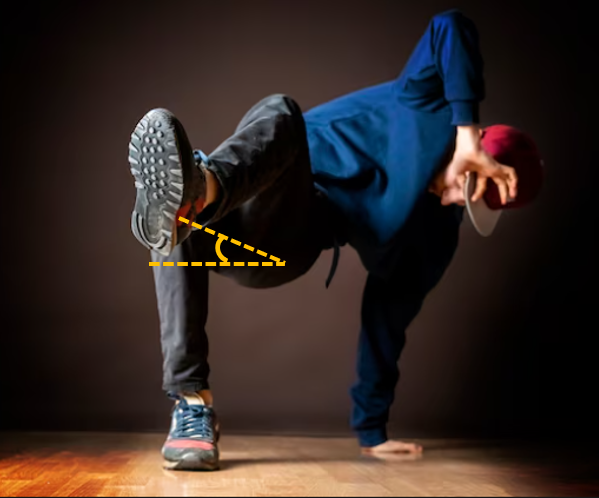

In [ ]:
#hip_knee_ankle.PNG
Image('/content/drive/MyDrive/Github/capstone/brace/figures/hip_knee_ankle.PNG')

In [ ]:
# Keypoint indices for right and left legs (hip, knee)
right_keypoints = [12, 14]  # right hip, right knee
left_keypoints = [11, 13]  # left hip, left knee

# Assuming 'data' is your padded_clips and 'labels' correspond to y_train
hrz_class_angles = extract_horizontal_angles_from_df(flattened_clips, encoded_categories, right_keypoints, left_keypoints)


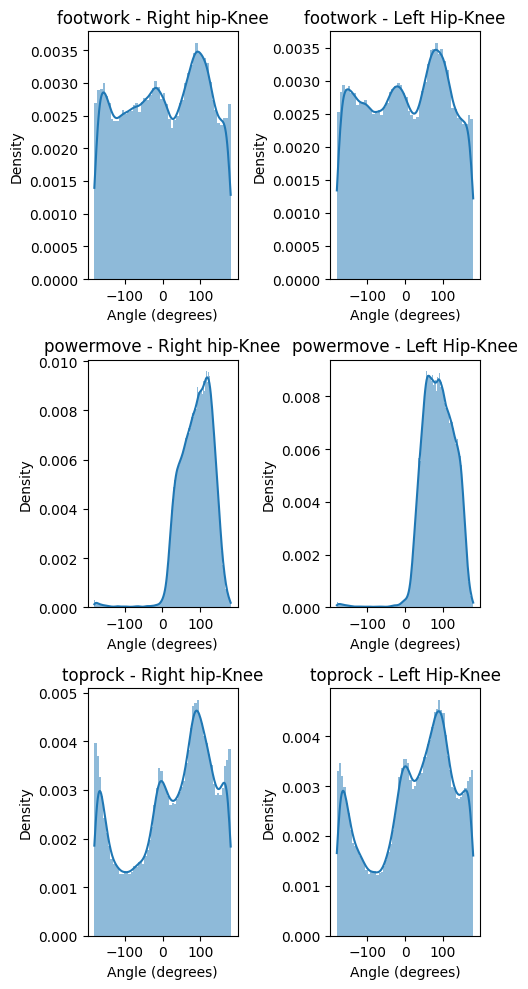

In [ ]:
plot_hip_knee_floor(hrz_class_angles, category_to_int)

In [ ]:
mean_horz_angles = calculate_mean_angles(hrz_class_angles)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_horz_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Hip-Knee-Floor Angle: {mean_horz_angles[label]['right']:.2f}, Mean Hip-Knee-Floor Angle: {mean_horz_angles[label]['left']:.2f}")

Class toprock - Mean Right Hip-Knee-Floor Angle: 24.52, Mean Hip-Knee-Floor Angle: 21.24
Class powermove - Mean Right Hip-Knee-Floor Angle: 88.57, Mean Hip-Knee-Floor Angle: 88.14
Class footwork - Mean Right Hip-Knee-Floor Angle: 2.85, Mean Hip-Knee-Floor Angle: 1.01


## Calculate distance from head to floor

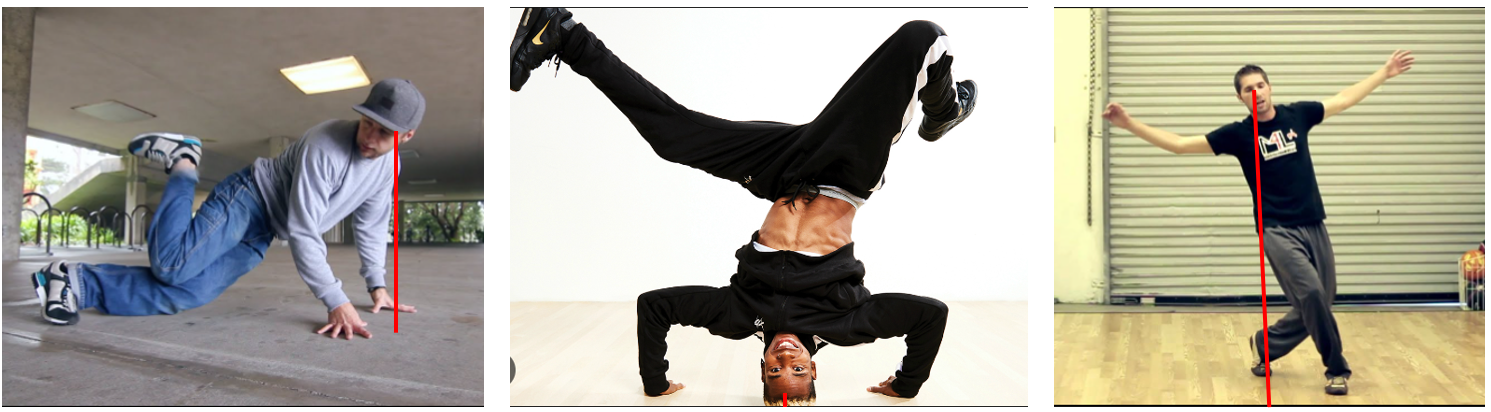

In [ ]:
Image('/content/drive/MyDrive/Github/capstone/brace/figures/head_floor.PNG')

In [ ]:
head_to_floor_distances = extract_head_to_floor_distances(flattened_clips, encoded_categories, category_to_int)
plot_head_to_floor_histograms(head_to_floor_distances)

In [ ]:
head_dist= calculate_mean_distance(head_to_floor_distances)
head_dist

{'toprock': 0.7607817715982209,
 'powermove': 0.9708167567989453,
 'footwork': 0.5077703016672418}

## Calculate distance from the wrists to floor

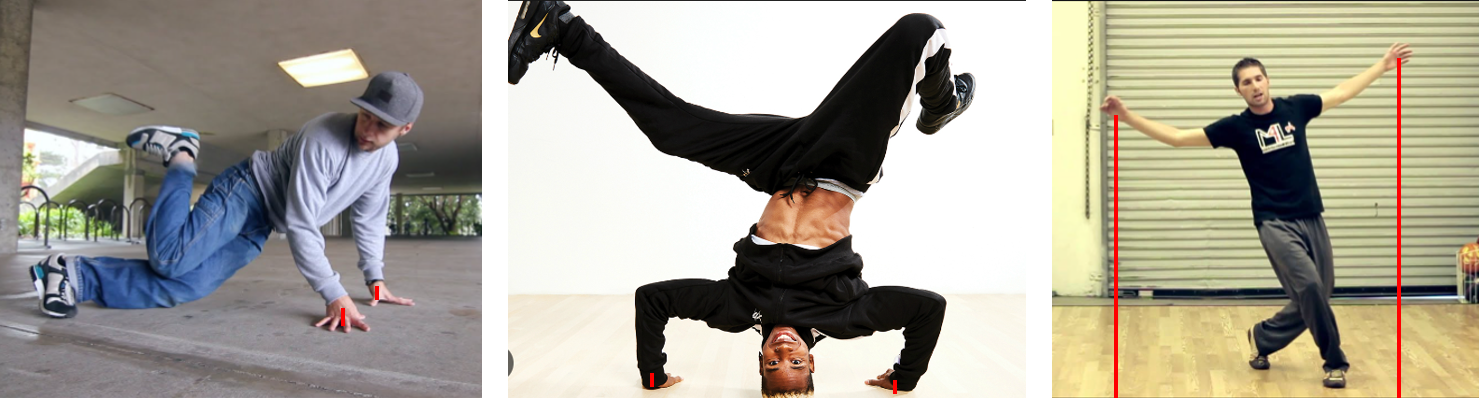

In [ ]:
Image('/content/drive/MyDrive/Github/capstone/brace/figures/wrists_floor.PNG')

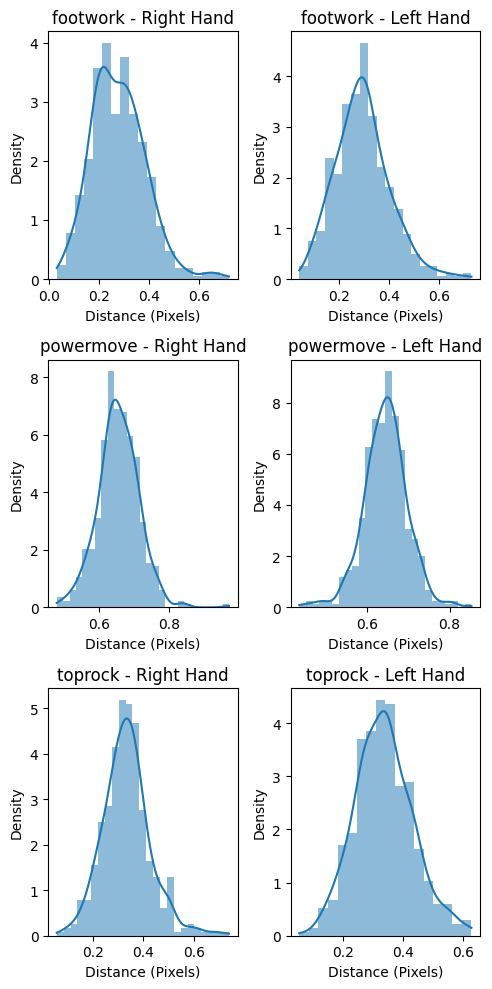

In [ ]:
hand_to_floor_distances = extract_hand_to_floor_distances(flattened_clips, encoded_categories)
plot_hand_distance_3x2_with_category_names(hand_to_floor_distances, category_to_int)

In [ ]:
mean_hand_angles = calculate_mean_hand_distance(hand_to_floor_distances)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_hand_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean right wrist to floor distance: {mean_hand_angles[label]['right']:.2f}, Mean left wrist to floor distance: {mean_hand_angles[label]['left']:.2f}")

Class toprock - Mean right wrist to floor distance: 0.33, Mean left wrist to floor distance: 0.34
Class powermove - Mean right wrist to floor distance: 0.66, Mean left wrist to floor distance: 0.64
Class footwork - Mean right wrist to floor distance: 0.28, Mean left wrist to floor distance: 0.29
